### In this notebook, we'll be taking a look at some data regarding diabetes indicators to see if we can make a deep learning model that accurately predicts an individual's likelihood of being diabetic, and what lifestyle changes would be the most effective for reducing that individual's risk.

### **IMPORTANT NOTE**: This project is not intended to serve as medical advice in any way, and instead is simply a means of demonstrating some analysis techniques via deep learning.

#### This project will use sklearn, pandas, and numpy to manage/clean/alter the data as necessary, and Tensorflow to build a deep learning model. Matplotlib will be used for some basic plotting, and we'll also throw in some Seaborn graphs later on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### First, let's load the data and check some basic metrics to get a better idea of what we're working with and how we should consider approaching the process.

In [2]:
df = pd.read_csv("data/diabetes_012_health_indicators_BRFSS2015.csv")
df.head()

Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1          1.0      3.0       0.0       0.0       0.0  0.0   7.0        6.0   
2          1.0      5.0      30.0      30.0       1.0  0.0   9.0        4.0   
3          0.0      2.0       0.0       0.0       0.0  0.0  11.0        3.0   
4          0.0      2.0       3.0       0.0       0.0  0.0  11.0        5.0   

   Income  
0     3.0  
1     1.0  
2     8.0  
3     6.0  
4     4.0  

[5 rows x 22 columns]

### One thing I notice right away is that there is some disparity in the scale between variables - for example, HighBP is either 0.0 or 1.0 but I can quickly see values between 0.0 and 30.0 for MentHlth. This leads me to believe that scaling the data could be a good idea, but we'll hold off on that until we split the X and y components apart.

### Knowing the shape of the data will be helpful, as it may help us decide how much of it we should train/test with

In [3]:
print(df.shape)

(253680, 22)


### 253,680 rows is quite a lot, and we will want to narrow this down quite substantially so that we can train our model quicker (at least until we've found a model we like, at which point we can increase our usage again if we desire). 
### Before narrowing it down, let's check if the dataset is biased, and if so how biased. The label column "Diabetes_012" denotes that there should be three classes, but let's check to be sure.

In [4]:
print(df["Diabetes_012"].value_counts())

0.0    213703
2.0     35346
1.0      4631
Name: Diabetes_012, dtype: int64


In [5]:
print("0.0: ", ((df["Diabetes_012"].value_counts()[0] / df.shape[0]) * 100), "%")
print("1.0: ", ((df["Diabetes_012"].value_counts()[1] / df.shape[0]) * 100), "%")
print("2.0: ", ((df["Diabetes_012"].value_counts()[2] / df.shape[0]) * 100), "%")

0.0:  84.24116997792494 %
1.0:  1.8255282245348472 %
2.0:  13.933301797540206 %


### This data is very biased!
### The dataset info on Kaggle says that a value of 0.0 represents no diabetes, whilst a value of 1.0 represents pre-diabetes or diabetes whilst pregnant, and a value of 2.0 represents diabetes. With that in mind, prediabetes/diabetes whilst pregnant seems to make up a remarkably insignificant portion of the data at ~1.8% representation compared to ~84.2% of non-diabetic and ~13.9% diabetic.

### Before leaning into any sort of conceptual analysis on what direction we should head in, let's whip up a quick basic model on the data as-is to see where it's lacking and what we should aim to improve on.

### We'll use sklearn to arrange our test/train splits. We'll use 80% of our data for training and the remaining 20% to test with, and for now we won't trim the data just so we have an idea of what the ceiling looks like for the basic model.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
X = df.drop(columns=["Diabetes_012"])

y = df["Diabetes_012"]

#Now that we've split the data is a good time to apply the MinMax scaler
#as we described above. The reason I'm doing it this way is so that I don't
#change the labels, as I'm fine with those remaining as they are.
#As an additional note, I've chosen to normalize the data instead of standardizing
#it (using standard scaler) because I want to retain the flat values in columns
#where 0/1 are representing false/true.
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#Split X and y into test and train splits using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [8]:
X[0]

array([1.        , 1.        , 1.        , 0.3255814 , 1.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.6       ,
       0.5       , 1.        , 0.        , 0.66666667, 0.6       ,
       0.28571429])

In [9]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers

In [10]:
#This basic model will have only one hidden layer, and the nodes within
#it will just be the average of the nodes in the input and output layers.
basic_model = models.Sequential([
        layers.Input(shape=(21,)),
        layers.Dense(12, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

basic_model.compile(
    loss=losses.sparse_categorical_crossentropy,
    optimizer=optimizers.Adam(0.001),
    metrics = ['sparse_categorical_accuracy'],
)

In [11]:
basic_log = basic_model.fit(X_train, y_train, epochs=10, verbose=True)

Epoch 1/10
6342/6342 [==============================] - 3s 485us/step - loss: 0.4203 - sparse_categorical_accuracy: 0.8436
Epoch 2/10
6342/6342 [==============================] - 3s 448us/step - loss: 0.4026 - sparse_categorical_accuracy: 0.8463
Epoch 3/10
6342/6342 [==============================] - 3s 460us/step - loss: 0.3989 - sparse_categorical_accuracy: 0.8472
Epoch 4/10
6342/6342 [==============================] - 3s 477us/step - loss: 0.3970 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
6342/6342 [==============================] - 3s 452us/step - loss: 0.3962 - sparse_categorical_accuracy: 0.8490
Epoch 6/10
6342/6342 [==============================] - 3s 440us/step - loss: 0.3956 - sparse_categorical_accuracy: 0.8490
Epoch 7/10
6342/6342 [==============================] - 3s 455us/step - loss: 0.3950 - sparse_categorical_accuracy: 0.8492
Epoch 8/10
6342/6342 [==============================] - 3s 464us/step - loss: 0.3948 - sparse_categorical_accuracy: 0.8491
Epoch 9/10
6342/

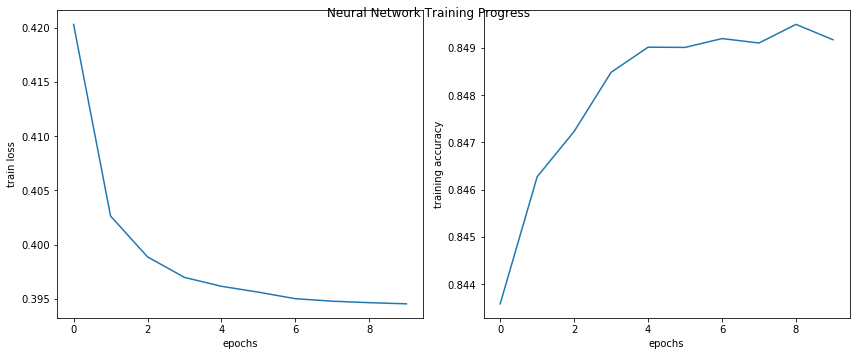

In [12]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(basic_log.history['loss'])
plt.ylabel('train loss')
plt.xlabel('epochs')

plt.subplot(1, 2, 2)
plt.plot(basic_log.history['sparse_categorical_accuracy'])
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.suptitle("Neural Network Training Progress\n\n")
plt.tight_layout()
plt.show()

In [13]:
print(pd.DataFrame(basic_log.history))

       loss  sparse_categorical_accuracy
0  0.420310                     0.843582
1  0.402639                     0.846273
2  0.398873                     0.847234
3  0.396979                     0.848485
4  0.396160                     0.849017
5  0.395620                     0.849013
6  0.395015                     0.849200
7  0.394787                     0.849106
8  0.394651                     0.849500
9  0.394544                     0.849175


### At a first glance, these results don't look too bad! The training accuracy is almost 85% after only 10 epochs!
### Let's dive a bit deeper into the types of predictions our model is making using a confusion matrix and see what we can find...

In [14]:
from sklearn.metrics import confusion_matrix

#We'll be using seaborn to plot the confusion matrix for visual clarity
import seaborn as sns

In [15]:
predictions = basic_model.predict(X_test)
prediction_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_test, prediction_classes)

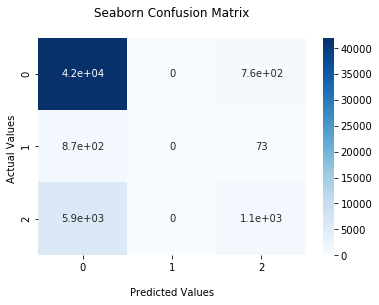

In [16]:
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the confusion matrix.
plt.show()

### Ahh, this makes sense... Not only is our model never predicting 1, but it is rarely predicting diabetes in those who are actually diabetic! This could be very bad in giving people a false sense of security when they are at risk!
### In all fairness, this is quite the expected outcome since non-diabetic is around 84% of the datset we are using. If you think about it, our model could be ~84% accurate just by only ever predicting that the patient isn't diabetic whilst ignoring the data entirely. This is a problem!

### From a conceptual standpoint of the problem that we're trying to solve with this project (predicting likelihood of diabetes and best improvements to reduce risk), I think that is worth chopping this data down to a binary representation of either non-diabetic or diabetic for the following reasons:
1. Prediabetes/pregnant diabetes (1.0) is extremely under-represented. We can address this with upsampling, but it is quite significantly behind the others and it would make the model less accurate at predicting 0.0 and 2.0
2. As hinted above, keeping a third class would almost certainly make our model worse at predicting the other two classes, which is likely not worth it if the scenario is naturally uncommon in the first place
3. Since we are looking to identify and analyze risk of diabetes (2.0) anyways, we actually don't mind if the grey area between 0.0 and 2.0 gets muddied a bit anyways - it will actually likely help us draw a more liberal estimate of when an individual is at risk 

### Considering all of the above, let's narrow our data down to 6,000 rows each of 0.0 and 2.0 labels. This will balance out the bias and since we're only using 12,000 rows instead of 246,000 and our training will be quicker at the expense of what is likely to be a slightly lower accuracy. This is fine, since we're planning on seeking the best model possible before we do the *real* training

In [17]:
df_0 = df[df.Diabetes_012 == 0.0]
df_2 = df[df.Diabetes_012 == 2.0]

#Print the shapes just to ensure everything looks correct
print(df_0.shape)
print(df_2.shape)

(213703, 22)
(35346, 22)


In [18]:
#We don't actually want to be using 0.0 and 2.0 as our labels in a binary solution, so let's change the 2.0s to 1.0s
#df_2.loc[:, "Diabetes_012"].replace(2.0, 1.0, inplace=True)
#TODO: This keeps raising a SettingWithCopyWarning despite using the exact notation that the warning
#suggests, try revisiting this at a later time.
df_2.loc[:, "Diabetes_012"] = 1.0

#Now let's combine the two parts to make our "balanced" dataset
df_balanced = pd.concat([df_0[:6000], df_2[:6000]])

#Since we are no longer using three classes, let's change the column name to represent this
df_balanced.rename(columns={"Diabetes_012": "Diabetes_01"}, inplace=True)

#Print the shape and value counts to ensure our final product is what we were aiming for
print(df_balanced.shape)
print(df_balanced["Diabetes_01"].value_counts())

(12000, 22)
1.0    6000
0.0    6000
Name: Diabetes_01, dtype: int64


C:\Users\Jake\anaconda3\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


### Now we must keep in mind that 1.0 no longer represents prediabetes/pregnant with diabetes, but instead just represents diabetes.
### Moving on, let's use sklearn to arrange our test/train splits. We'll use 80% of our data for training and the remaining 20% to test with again.

In [19]:
X = df_balanced.drop(columns=["Diabetes_01"])
y = df_balanced["Diabetes_01"]

#Split X and y into test and train splits using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### We'll clear and rebuild the basic model to see how the data adjustments have affected our results. We'll make a couple small changes to the output layer to account for the fact that we've changed the problem to a binary one.

In [20]:
#TODO: I'm honestly still not certain if this clear_session is mandatory or not. Investigate this.
import tensorflow.keras.backend as backend

In [21]:
backend.clear_session()

#This basic model will have only one hidden layer, and the nodes within
#it will just be the average of the nodes in the input and output layers.
basic_model = models.Sequential([
        layers.Input(shape=(21,)),
        layers.Dense(12, activation='relu'),
        layers.Dense(2, activation='sigmoid') #Size of 2 for binary and sigmoid instead of softmax activation
    ])

basic_model.compile(
    loss=losses.sparse_categorical_crossentropy,
    optimizer=optimizers.Adam(0.001),
    metrics = ['sparse_categorical_accuracy'],
)

In [22]:
basic_log = basic_model.fit(X_train, y_train, epochs=10, verbose=True)

Epoch 1/10
300/300 [==============================] - 0s 452us/step - loss: 0.7896 - sparse_categorical_accuracy: 0.5871
Epoch 2/10
300/300 [==============================] - 0s 485us/step - loss: 0.6079 - sparse_categorical_accuracy: 0.6759
Epoch 3/10
300/300 [==============================] - 0s 435us/step - loss: 0.5879 - sparse_categorical_accuracy: 0.6913
Epoch 4/10
300/300 [==============================] - 0s 428us/step - loss: 0.5749 - sparse_categorical_accuracy: 0.7040
Epoch 5/10
300/300 [==============================] - 0s 427us/step - loss: 0.5700 - sparse_categorical_accuracy: 0.7088
Epoch 6/10
300/300 [==============================] - 0s 432us/step - loss: 0.5657 - sparse_categorical_accuracy: 0.7076
Epoch 7/10
300/300 [==============================] - 0s 439us/step - loss: 0.5654 - sparse_categorical_accuracy: 0.7065
Epoch 8/10
300/300 [==============================] - 0s 445us/step - loss: 0.5615 - sparse_categorical_accuracy: 0.7152
Epoch 9/10
300/300 [============

### Well, that training was certainly a LOT faster, but our accuracy went down! What gives?

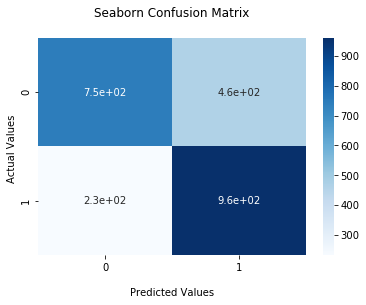

In [23]:
predictions = basic_model.predict(X_test)
prediction_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_test, prediction_classes)

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the confusion matrix.
plt.show()

In [24]:
print(conf_matrix)

recall = (conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1]))
print(recall)

[[746 462]
 [231 961]]
0.8062080536912751


### Wow, that looks WAY better. The darker colours fall along the diagonal where predicted values and actual values align, which very clearly demonstrates that our model is actually making a real effort to predict diabetes now! It may only be ~71% accurate (on the training data), but this is a much more realistic set of predictions. Ideally, if we can make the bottom right corner (diabetic) slightly darker, this can be really effective for our ambitions. As I've printed above, recall score is actually incredibly important for us, because we really want to minimize the amount of cases where we predict that a diabetic patient is actually not diabetic.

### Since the model seems at least somewhat reputable, let's check some more metrics on the test data to get some more baselines. This time we'll use sklearn and verify what we calculated manually for recall score as well to ensure we're seeking the right optimizations.

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [26]:
metrics = []

metrics.append([
    basic_model.name,
    accuracy_score(y_test, prediction_classes),
    precision_score(y_test, prediction_classes),
    recall_score(y_test, prediction_classes),
    f1_score(y_test, prediction_classes)
])
        
metrics_df = pd.DataFrame(metrics)
metrics_df.columns = ['Model_Name', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']

print(metrics_df)

#Saving these metrics for side-by-side comparison down the road.
basic_model_metrics = metrics_df

   Model_Name  Test_Accuracy  Test_Precision  Test_Recall  Test_F1
0  sequential        0.71125        0.675334     0.806208  0.73499


### The recall matches our calculations, and now that we have a reasonable baseline that we can aim to beat, let's try to make a better model. In the pursuit of minimizing guesswork, the first thing I'd like to do is sample a diverse range of models with 3 hidden layers instead of 1 and varying amounts of nodes. If we find one that performs well, we can pursue further optimizations to that architecture.

In [27]:
#Setting up some parameters to help me generate all of the configurations for testing
num_layers = 3 # I want this many hidden layers
min_nodes_per_layer = 32
max_nodes_per_layer = 128
node_step_size = 32

node_possibilities = list(range(
    min_nodes_per_layer, 
    max_nodes_per_layer + 1, 
    node_step_size
))

#Print the possibilities for one layer
print(node_possibilities)

print()
#If we have 3 hidden layers, our possibilities will look more like:
three_layer_possibilities = [node_possibilities, node_possibilities, node_possibilities]
print(three_layer_possibilities)

[32, 64, 96, 128]

[[32, 64, 96, 128], [32, 64, 96, 128], [32, 64, 96, 128]]


In [28]:
#We'll use an iteration tool to find all of the possible permutations
import itertools

In [29]:
layer_possibilities = [node_possibilities] * num_layers
layer_node_permutations = list(itertools.product(*three_layer_possibilities))

#Print just a handfull of the permutations to ensure that they're
#as we'd expect
print(layer_node_permutations[:10])

[(32, 32, 32), (32, 32, 64), (32, 32, 96), (32, 32, 128), (32, 64, 32), (32, 64, 64), (32, 64, 96), (32, 64, 128), (32, 96, 32), (32, 96, 64)]


In [30]:
#Now we can finally start to build all of the models
models_list = []

for permutation in layer_node_permutations:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(21,)))
    model_name = ''
    
    for nodes_at_layer in permutation:
        model.add(tf.keras.layers.Dense(nodes_at_layer, activation='relu'))
        model_name += f'dense{nodes_at_layer}_'
        
    model.add(layers.Dense(2, activation='sigmoid'))
    model._name = model_name[:-1]
    
    models_list.append(model)

In [31]:
#Let's check in on the 10th model to ensure that everything looks correct:
models_list[9].summary()

Model: "dense32_dense96_dense64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 32)                704       
_________________________________________________________________
dense_39 (Dense)             (None, 96)                3168      
_________________________________________________________________
dense_40 (Dense)             (None, 64)                6208      
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 130       
Total params: 10,210
Trainable params: 10,210
Non-trainable params: 0
_________________________________________________________________


### Everything looks good for the model we sampled, now let's actually compile and train them all!

In [32]:
results = []
metrics = []
progress = 0

for model in models_list:
        try:
            model.compile(
                loss=losses.sparse_categorical_crossentropy,
                optimizer=optimizers.Adam(0.001),
                metrics = ['sparse_categorical_accuracy'],
            )
            print(((progress + 1)/len(models_list)) * 100, "% complete  \r",end='')
            log = model.fit(X_train, y_train, epochs=10, verbose=False)
            res = log.history
            results.append(res)
            
            #Now we'll add in some lines to gather metrics from the model using the test data
            predictions = model.predict(X_test)
            prediction_classes = np.argmax(predictions, axis=1)

            metrics.append([
                model.name,
                accuracy_score(y_test, prediction_classes),
                precision_score(y_test, prediction_classes),
                recall_score(y_test, prediction_classes),
                f1_score(y_test, prediction_classes)
            ])
        except Exception as e:
            print(f'{model.name} --> {str(e)}')
        progress += 1


In [33]:
metrics_df = pd.DataFrame(metrics)
metrics_df.columns = ['Model_Name', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']

metrics_df.head()

Model_Name  Test_Accuracy  Test_Precision  Test_Recall  \
0   dense32_dense32_dense32       0.714167        0.680456     0.800336   
1   dense32_dense32_dense64       0.717083        0.686275     0.792785   
2   dense32_dense32_dense96       0.697083        0.708895     0.661913   
3  dense32_dense32_dense128       0.714167        0.682540     0.793624   
4   dense32_dense64_dense32       0.714583        0.673988     0.823826   

    Test_F1  
0  0.735544  
1  0.735695  
2  0.684599  
3  0.733902  
4  0.741412

In [34]:
metrics_df.sort_values(by='Test_Recall', ascending=False)

Model_Name  Test_Accuracy  Test_Precision  Test_Recall  \
53   dense128_dense64_dense64       0.701667        0.644945     0.888423   
29   dense64_dense128_dense64       0.703333        0.647059     0.885906   
59  dense128_dense96_dense128       0.710000        0.655194     0.878356   
38    dense96_dense64_dense96       0.711250        0.656623     0.877517   
48   dense128_dense32_dense32       0.711667        0.657233     0.876678   
..                        ...            ...             ...          ...   
50   dense128_dense32_dense96       0.703333        0.708333     0.684564   
2     dense32_dense32_dense96       0.697083        0.708895     0.661913   
23   dense64_dense64_dense128       0.688333        0.729339     0.592282   
17    dense64_dense32_dense64       0.676667        0.734234     0.546980   
10    dense32_dense96_dense96       0.664167        0.718326     0.532718   

     Test_F1  
53  0.747354  
29  0.747875  
59  0.750538  
38  0.751167  
48  0.751258  
..       ...  
50  0.696246  
2   0.684599  
23  0.653704  
17  0.626923  
10  0.611753  

[64 rows x 5 columns]

In [35]:
best_model_index = metrics_df['Test_Recall'].idxmax()
print(metrics_df.loc[best_model_index])
print()
print(layer_node_permutations[best_model_index])

Model_Name        dense128_dense64_dense64
Test_Accuracy                     0.701667
Test_Precision                    0.644945
Test_Recall                       0.888423
Test_F1                           0.747354
Name: 53, dtype: object

(128, 64, 64)


In [36]:
print(basic_model_metrics)

   Model_Name  Test_Accuracy  Test_Precision  Test_Recall  Test_F1
0  sequential        0.71125        0.675334     0.806208  0.73499


### As we can see, the recall of the best model from our sampling is much better (92% compared to only 74%), but there is still some room for improvement as our test precision is considerably lower. I'm happy that recall is better, and that is most important, but it doesn't hurt to aim for a better model overall.

### Let's take the same features our best model had and build a new one where we optimize the learning rate.

In [37]:
#TODO: Can I duplicate the model or copy the weights discovered from 
#the previous exploration instead of rebuilding a model with the same features?

#This model is based on our findings above, and features 3 hidden layers
best_model = models.Sequential([
        layers.Input(shape=(21,)),
        layers.Dense(layer_node_permutations[best_model_index][0], activation='relu'),
        layers.Dense(layer_node_permutations[best_model_index][1], activation='relu'),
        layers.Dense(layer_node_permutations[best_model_index][2], activation='relu'),
        layers.Dense(2, activation='sigmoid')
    ])

best_model.compile(
    loss=losses.sparse_categorical_crossentropy,
    optimizer=optimizers.Adam(),
    metrics = ['sparse_categorical_accuracy'],
)

In [38]:
learning_rate_history = best_model.fit(
    X_train,
    y_train,
    epochs=50,  #Since we know suspect this model to be a decent performer,
                 #let's add some epochs to allow for more learning rate comparisons
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-3 * 10 ** (epoch / 20)
            #Question: What happens if we reverse the "direction" of change?
            #ie. start with high learning rate and end with low
            #will the graph still look similar? is higher epoch benefitting
            #from previous progress?
        )
    ]
)

Epoch 1/50
300/300 [==============================] - 0s 690us/step - loss: 0.6054 - sparse_categorical_accuracy: 0.6693
Epoch 2/50
300/300 [==============================] - 0s 733us/step - loss: 0.5670 - sparse_categorical_accuracy: 0.6982
Epoch 3/50
300/300 [==============================] - 0s 713us/step - loss: 0.5624 - sparse_categorical_accuracy: 0.7083
Epoch 4/50
300/300 [==============================] - 0s 639us/step - loss: 0.5555 - sparse_categorical_accuracy: 0.7065
Epoch 5/50
300/300 [==============================] - 0s 639us/step - loss: 0.5538 - sparse_categorical_accuracy: 0.7113
Epoch 6/50
300/300 [==============================] - 0s 639us/step - loss: 0.5510 - sparse_categorical_accuracy: 0.7190
Epoch 7/50
300/300 [==============================] - 0s 643us/step - loss: 0.5529 - sparse_categorical_accuracy: 0.7154
Epoch 8/50
300/300 [==============================] - 0s 730us/step - loss: 0.5478 - sparse_categorical_accuracy: 0.7161
Epoch 9/50
300/300 [============

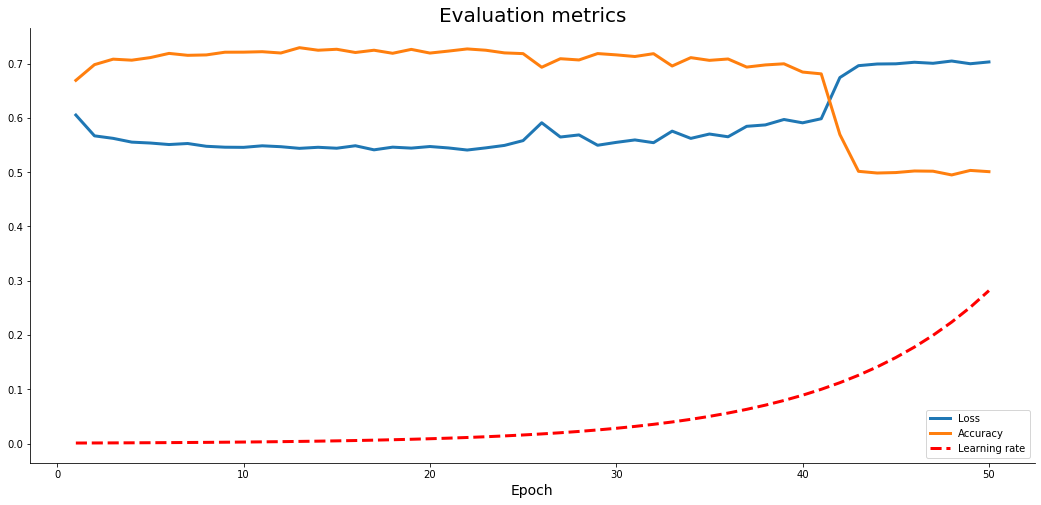

In [39]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False 

plt.plot(
    np.arange(1, 51), 
    learning_rate_history.history['loss'], 
    label='Loss', lw=3
)
plt.plot(
    np.arange(1, 51), 
    learning_rate_history.history['sparse_categorical_accuracy'], 
    label='Accuracy', lw=3
)
plt.plot(
    np.arange(1, 51), 
    learning_rate_history.history['lr'], 
    label='Learning rate', color='red', lw=3, linestyle='--'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

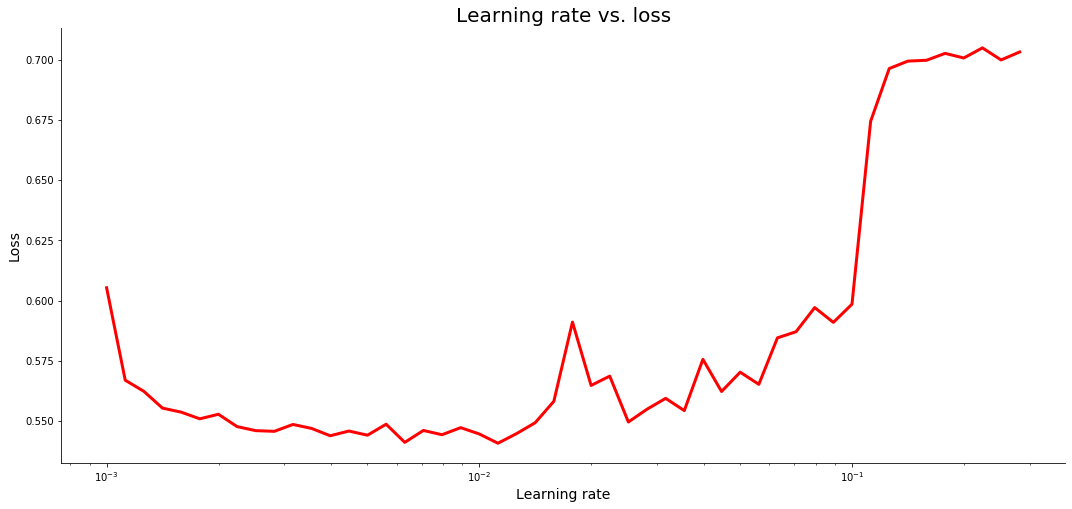

In [40]:
learning_rates = 1e-3 * (10 ** (np.arange(50) / 20))

plt.semilogx(
    learning_rates, 
    learning_rate_history.history['loss'], 
    lw=3, color='red'
)
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14);

In [41]:
print(min(learning_rate_history.history['loss']))
minloc = np.argmin(learning_rate_history.history['loss'])
print(minloc)
print(learning_rate_history.history['loss'][minloc])
print(learning_rates[minloc])

0.5408924221992493
21
0.5408924221992493
0.011220184543019636


In [42]:
backend.clear_session()

#This basic model will have only one hidden layer, and the nodes within
#it will just be the average of the nodes in the input and output layers.
best_model = models.Sequential([
        layers.Input(shape=(21,)),
        layers.Dense(layer_node_permutations[best_model_index][0], activation='relu'),
        layers.Dense(layer_node_permutations[best_model_index][1], activation='relu'),
        layers.Dense(layer_node_permutations[best_model_index][2], activation='relu'),
        layers.Dense(2, activation='sigmoid')
    ])

best_model.compile(
    loss=losses.sparse_categorical_crossentropy,
    #optimizer=optimizers.Adam(0.001),
    optimizer=optimizers.Adam(learning_rates[minloc]),
    metrics = ['sparse_categorical_accuracy'],
)

In [43]:
best_log = best_model.fit(X_train, y_train, epochs=50, verbose=True)

Epoch 1/50
300/300 [==============================] - 0s 726us/step - loss: 0.6439 - sparse_categorical_accuracy: 0.6691
Epoch 2/50
300/300 [==============================] - 0s 727us/step - loss: 0.5722 - sparse_categorical_accuracy: 0.7009
Epoch 3/50
300/300 [==============================] - 0s 693us/step - loss: 0.5674 - sparse_categorical_accuracy: 0.7077
Epoch 4/50
300/300 [==============================] - 0s 643us/step - loss: 0.5599 - sparse_categorical_accuracy: 0.7120
Epoch 5/50
300/300 [==============================] - 0s 629us/step - loss: 0.5615 - sparse_categorical_accuracy: 0.7141
Epoch 6/50
300/300 [==============================] - 0s 637us/step - loss: 0.5534 - sparse_categorical_accuracy: 0.7206
Epoch 7/50
300/300 [==============================] - 0s 636us/step - loss: 0.5539 - sparse_categorical_accuracy: 0.7158
Epoch 8/50
300/300 [==============================] - 0s 629us/step - loss: 0.5486 - sparse_categorical_accuracy: 0.7222
Epoch 9/50
300/300 [============

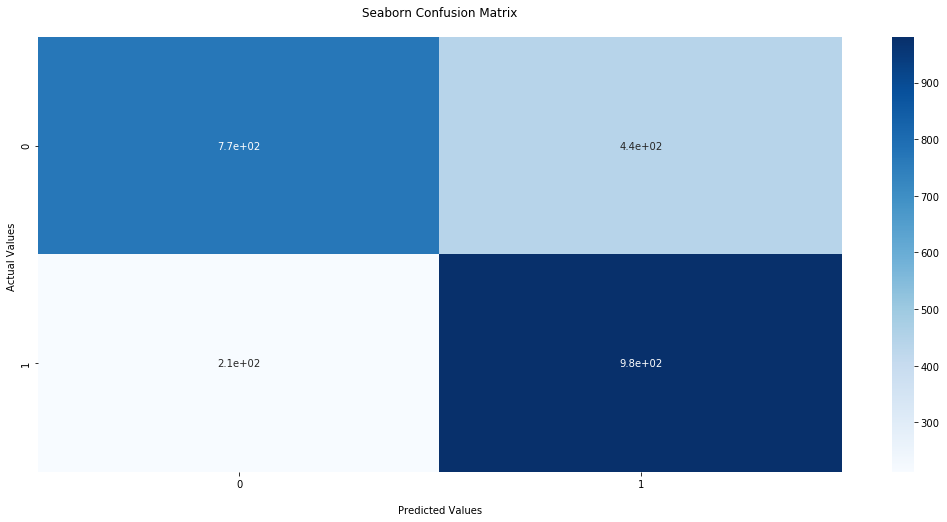

In [44]:
predictions = best_model.predict(X_test)
prediction_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_test, prediction_classes)

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the confusion matrix.
plt.show()

In [45]:
best_metrics = []

best_metrics.append([
    best_model.name,
    accuracy_score(y_test, prediction_classes),
    precision_score(y_test, prediction_classes),
    recall_score(y_test, prediction_classes),
    f1_score(y_test, prediction_classes)
])
        
best_metrics_df = pd.DataFrame(best_metrics)
best_metrics_df.columns = ['Model_Name', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']

print(best_metrics_df)

#Saving these metrics for side-by-side comparison down the road.
best_model_metrics = best_metrics_df

   Model_Name  Test_Accuracy  Test_Precision  Test_Recall   Test_F1
0  sequential       0.728333        0.690141     0.822148  0.750383


TODO: Revisit this cell after further optimizations above
### Now that we have a model we're somewhat satisfied with, let's apply it to the solution we proposed earlier, which we'll break down into two parts:
  1. We'd like to use our model to predict an individual's likelihood of being diabetic. 
  2. Whether they are or not, I think it would be even more helpful if we could give them the top three ranking lifestyle changes that they could make to reduce their risk. 
### *Important*: #2 should be customized for each individual's circumstances, and not based on overall statistics pulled from the entire dataset.

### Starting with number 1, let's take a peek at the 0th "patient" from our test dataset and use our model to come up with a prediction.

In [46]:
print(X_test.iloc[0])

HighBP                   1.0
HighChol                 1.0
CholCheck                1.0
BMI                     26.0
Smoker                   1.0
Stroke                   0.0
HeartDiseaseorAttack     0.0
PhysActivity             0.0
Fruits                   0.0
Veggies                  0.0
HvyAlcoholConsump        0.0
AnyHealthcare            0.0
NoDocbcCost              0.0
GenHlth                  3.0
MentHlth                 0.0
PhysHlth                 0.0
DiffWalk                 0.0
Sex                      0.0
Age                      7.0
Education                5.0
Income                   1.0
Name: 7117, dtype: float64


In [47]:
print(pd.DataFrame(best_model.predict(X_test)).iloc[0])

0    0.524391
1    0.548341
Name: 0, dtype: float32


### As we can see above, our model would predict 0, or non-diabetic, for patient 0 as that entry has the highest value for that row.
### Now, we should aim to see how we can change this to either reduce the confidence of a 1 or increase the confidence of a 0. To do this, let's take a look at the columns and decide on some that can be adjusted with lifestyle changes.

In [48]:
print(X.columns)

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


In [49]:
lifestyleColumns = ['HighBP', 'HighChol', 'BMI',
                    'Smoker', 'PhysActivity', 'Fruits',
                    'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare']

### Above, I've decided on some columns that can be either directly (such as fruit/veggie consumption) or indirectly (such as BMI) changed via lifestyle adjustments. This is honestly kind of subjective, and some of it is certainly up to debate but I don't feel that income is a reasonable adjustment to be advised of, for example.
### With these columns in mind, my goal is to make a list of patients identical to patient 0, but each with only 1 different parameter from the original.
### It's worth noting that when making this list, we mustn't assume whether a factor's resulting impact is negative or positive in either direction. Instead, we should just let the model determine that for us. Because of this, I'm comfortable with flipping the factor's value from a 0.0 to 1.0 or vice-versa, even if it means it's setting a variable in a direction that's traditionally thought of as more negative, such as the blood pressure factor to high instead of low. We will see the impact of this later.

In [50]:
selectedPatient = X_test.iloc[0]
patientChanges = [selectedPatient]

for factor in lifestyleColumns:
    tmpPatient = selectedPatient.copy()
    if (factor == 'BMI'):
        tmpPatient[factor] -= (0.1 * tmpPatient[factor]) 
    else:
        if (tmpPatient[factor] == 0.0):
            tmpPatient[factor] = 1.0
        elif (tmpPatient[factor] == 1.0):
            tmpPatient[factor] = 0.0
        else:
            print(" -----  nothing happened -----  ")
    patientChanges.append(tmpPatient)
    
print(pd.DataFrame(patientChanges, index=np.arange(0, 10)))

   HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0        1.0  26.0     1.0     0.0                   0.0   
1     0.0       1.0        1.0  26.0     1.0     0.0                   0.0   
2     1.0       0.0        1.0  26.0     1.0     0.0                   0.0   
3     1.0       1.0        1.0  23.4     1.0     0.0                   0.0   
4     1.0       1.0        1.0  26.0     0.0     0.0                   0.0   
5     1.0       1.0        1.0  26.0     1.0     0.0                   0.0   
6     1.0       1.0        1.0  26.0     1.0     0.0                   0.0   
7     1.0       1.0        1.0  26.0     1.0     0.0                   0.0   
8     1.0       1.0        1.0  26.0     1.0     0.0                   0.0   
9     1.0       1.0        1.0  26.0     1.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0           0.0     0.0      0.0  ...            0.0          0

### With this list of theoretical patients, let's run some predictions using our model

In [51]:
patientResults = pd.DataFrame(best_model.predict(pd.DataFrame(patientChanges)))
print(patientResults)

          0         1
0  0.524391  0.548341
1  0.582076  0.474689
2  0.577518  0.479588
3  0.539018  0.522257
4  0.518824  0.558184
5  0.529047  0.540069
6  0.508946  0.575515
7  0.528206  0.541567
8  0.632578  0.419738
9  0.522788  0.551180


### In all of the rows where the value in column 1 is greater than that of column 2, the prediction is that said patient is diabetic. Remember that row 0 represents the actual patient we took from the data, or our baseline. With that in mind, how could we best measure the improvement or decline in someone's likelihood of being diabetic?
  1. We could measure the increase in column 0 compared to the baseline
  2. We could measure the decrease in column 0 compared to the baseline
  3. We can measure the difference in the delta between 0 and 1 compared to the baseline.
### Ideas 1 and 2 are easy to come up with and very simple overall, but I like idea 3 as it measures from both angles to get what I believe to be the most true representation of the gain or loss in our model predicting non-diabetic. Let's implement that now.

In [52]:
#Find the delta between confidence of diabetic vs non-diabetic prediction
patientResults['Delta'] = patientResults[1] - patientResults[0]

#Compare the delta of each row to baseline (row 0) to get our metric
patientResults['Delta Difference'] = patientResults['Delta'] - patientResults['Delta'].iloc[0]

#Add in a label to indicate which variable was edited for each hypothetical patient
#Note: I'm re-declaring lifestyleColumns because re-running this cell would otherwise
#add another "baseline" to the list and mess with our proper indexing
lifestyleColumns = ['HighBP', 'HighChol', 'BMI',
                    'Smoker', 'PhysActivity', 'Fruits',
                    'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare']
rowLabels = ["Baseline"] + lifestyleColumns
patientResults['LifestyleChange'] = rowLabels

print(patientResults)

          0         1     Delta  Delta Difference    LifestyleChange
0  0.524391  0.548341  0.023950          0.000000           Baseline
1  0.582076  0.474689 -0.107387         -0.131337             HighBP
2  0.577518  0.479588 -0.097931         -0.121881           HighChol
3  0.539018  0.522257 -0.016761         -0.040711                BMI
4  0.518824  0.558184  0.039360          0.015410             Smoker
5  0.529047  0.540069  0.011022         -0.012929       PhysActivity
6  0.508946  0.575515  0.066569          0.042619             Fruits
7  0.528206  0.541567  0.013362         -0.010589            Veggies
8  0.632578  0.419738 -0.212840         -0.236791  HvyAlcoholConsump
9  0.522788  0.551180  0.028393          0.004442      AnyHealthcare


### Okay, now that we have the numbers in front of us how should we interpret this? Well, the "Delta" column represents column 1 - column 0, therefore the lower the number for that column is, the better. A very low "Delta" means that the model would be far more confident in predicting non-diabetic than diabetic, which is good for the patient!
### Delta Difference, then, is representing how the current row's Delta compares to the baseline. Once again, since we've subtracted the baseline from the current row, a lower number is better here. Let's sort with that in mind and make some observations.

In [53]:
patientResultsSorted = patientResults.sort_values(by=['Delta Difference'])
print(patientResultsSorted)

          0         1     Delta  Delta Difference    LifestyleChange
8  0.632578  0.419738 -0.212840         -0.236791  HvyAlcoholConsump
1  0.582076  0.474689 -0.107387         -0.131337             HighBP
2  0.577518  0.479588 -0.097931         -0.121881           HighChol
3  0.539018  0.522257 -0.016761         -0.040711                BMI
5  0.529047  0.540069  0.011022         -0.012929       PhysActivity
7  0.528206  0.541567  0.013362         -0.010589            Veggies
0  0.524391  0.548341  0.023950          0.000000           Baseline
9  0.522788  0.551180  0.028393          0.004442      AnyHealthcare
4  0.518824  0.558184  0.039360          0.015410             Smoker
6  0.508946  0.575515  0.066569          0.042619             Fruits


### It may look a little weird that changing the patient's HighBP column resulted in a higher likelihood of diabetes, but remember that we arranged our patient list such that the value would be flipped. Thus, the HighBP column could have been false and been swapped to true, for example.
TODO: Fix below statement - prediction may change with rerun
### Apart from that, it could be said that based on our model's predictions, the three lifestyle changes that would most greatly reduce the patient's risk of diabetes would be changing their high cholesterol status, changing their heavy alcohol consumption habits, and reducing their BMI by a factor of 10%. More specifically, we can check what the original values for these columns were to decide which direction they should shift in.

In [54]:
change1 = patientResultsSorted["LifestyleChange"].iloc[0]
change2 = patientResultsSorted["LifestyleChange"].iloc[1]
change3 = patientResultsSorted["LifestyleChange"].iloc[2]
print("{} Original Value: ".format(change1) + str(patientChanges[0][change1]))
print("{} Original Value: ".format(change2) + str(patientChanges[1][change2]))
print("{} Original Value: ".format(change3) + str(patientChanges[2][change3]))

print()
#print index of best change
print(patientResultsSorted.iloc[0].name)

HvyAlcoholConsump Original Value: 0.0
HighBP Original Value: 0.0
HighChol Original Value: 0.0

8


### Using the above information, we can print a nice little statement for the given patient that provides them with the main takeaways that our model generates.

In [55]:
print("Based on our deep learning model, the recommended lifestyle \nchanges to reduce diabetes risk for the selected patient are: \n")
print("1: {} from {} to {}, with a change in likelihood of {}".format((change1),(patientChanges[0][change1]),
    (patientChanges[patientResultsSorted.iloc[0].name][change1]),(patientResultsSorted['Delta Difference'].iloc[0])))
print("2: {} from {} to {}, with a change in likelihood of {}".format((change2),(patientChanges[0][change2]),
    (patientChanges[patientResultsSorted.iloc[1].name][change2]),(patientResultsSorted['Delta Difference'].iloc[1])))
print("3: {} from {} to {}, with a change in likelihood of {}".format((change3),(patientChanges[0][change3]),
    (patientChanges[patientResultsSorted.iloc[2].name][change3]),(patientResultsSorted['Delta Difference'].iloc[2])))

Based on our deep learning model, the recommended lifestyle 
changes to reduce diabetes risk for the selected patient are: 

1: HvyAlcoholConsump from 0.0 to 1.0, with a change in likelihood of -0.23679068684577942
2: HighBP from 1.0 to 0.0, with a change in likelihood of -0.1313372552394867
3: HighChol from 1.0 to 0.0, with a change in likelihood of -0.12188112735748291


### Now all that's left for us is to package this more nicely into a single function instead of working piecewise across multiple cells and put in some quality of life changes, such as not recommending things that worsen the likelihood of diabetes (for example, in a patient who would see no improvements from any lifestyle changes) 

In [56]:
def patientAdvice(patient, model=best_model):
    #Initialize an empty array of theoretical patients
    patientChanges = []
    
    #Add the selected patient to the array of patients -- this will serve as our
    #baseline patient, with no changes to their current set of features
    patientChanges.append(patient)
    
    #Iterate over each of the features that are changeable (lifestyle),
    #and create a theoretical patient as if they were to have made only that change
    lifestyleColumns = ['HighBP', 'HighChol', 'BMI', 'Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare']
    for factor in lifestyleColumns:
        tmpPatient = patient.copy()
        if (factor == 'BMI'):
            tmpPatient[factor] -= (0.1 * tmpPatient[factor]) 
        else:
            if (tmpPatient[factor] == 0.0):
                tmpPatient[factor] = 1.0
            elif (tmpPatient[factor] == 1.0):
                tmpPatient[factor] = 0.0
            else:
                # TODO: Change to try/catch with error statement
                print(" -----  nothing happened -----  ")
        patientChanges.append(tmpPatient)

    
    #This will be used to align our generated output with the proper labels so we can identify the changes
    rowNames = ['Baseline', 'HighBP', 'HighChol', 'BMI', 'Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare']
    
    #Use our model to predict the likelihood of diabetes in each of the theoretical patients
    patientResults = pd.DataFrame(model.predict(pd.DataFrame(patientChanges)))
    #Find the delta between confidence of diabetic vs non-diabetic prediction
    patientResults['Delta'] = patientResults[1] - patientResults[0]

    #Compare the delta of each row to baseline (row 0) to get our metric
    patientResults['Delta Difference'] = patientResults['Delta'] - patientResults['Delta'].iloc[0]
    
    #Add in a label to indicate which variable was edited for each hypothetical patient
    #Note: I'm re-declaring lifestyleColumns because re-running this cell would otherwise
    #add another "baseline" to the list and mess with our proper indexing
    lifestyleColumns = ['HighBP', 'HighChol', 'BMI',
                        'Smoker', 'PhysActivity', 'Fruits',
                        'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare']
    rowLabels = ["Baseline"] + lifestyleColumns
    patientResults['LifestyleChange'] = rowLabels
    
    #Sort the result by change in risk and output useful information
    patientResultsSorted = patientResults.sort_values(by=['Delta Difference'])
    print(patientResultsSorted)
    change1 = patientResultsSorted["LifestyleChange"].iloc[0]
    change2 = patientResultsSorted["LifestyleChange"].iloc[1]
    change3 = patientResultsSorted["LifestyleChange"].iloc[2]
    print("")
    if ((patientResultsSorted['Delta Difference'].iloc[0]) < 0.0):
        print("Based on our deep learning model, the recommended lifestyle \nchanges to reduce diabetes risk for the selected patient are: \n")
        print("1: {} from {} to {}, with a change in likelihood of {}".format((change1),(patientChanges[0][change1]),
            (patientChanges[patientResultsSorted.iloc[0].name][change1]),(patientResultsSorted['Delta Difference'].iloc[0])))
        if ((patientResultsSorted['Delta Difference'].iloc[1]) < 0.0):
            print("2: {} from {} to {}, with a change in likelihood of {}".format((change2),(patientChanges[0][change2]),
                (patientChanges[patientResultsSorted.iloc[1].name][change2]),(patientResultsSorted['Delta Difference'].iloc[1])))
            if ((patientResultsSorted['Delta Difference'].iloc[2]) < 0.0):
                print("3: {} from {} to {}, with a change in likelihood of {}".format((change3),(patientChanges[0][change3]),
                (patientChanges[patientResultsSorted.iloc[2].name][change3]),(patientResultsSorted['Delta Difference'].iloc[2])))
    else:
        print("Congratulations! According to our model, there are no recommended improvements to the given patient's"
              " current lifestyle that would decrease their likelihood of diabetes!")

In [57]:
patientAdvice(X_test.iloc[1])

          0         1     Delta  Delta Difference    LifestyleChange
8  0.481302  0.622896  0.141594         -0.147673  HvyAlcoholConsump
1  0.458623  0.660253  0.201630         -0.087637             HighBP
2  0.456629  0.663463  0.206835         -0.082432           HighChol
3  0.441516  0.687364  0.245847         -0.043420                BMI
6  0.439496  0.690499  0.251003         -0.038264             Fruits
4  0.429780  0.705380  0.275600         -0.013667             Smoker
9  0.425892  0.711238  0.285346         -0.003921      AnyHealthcare
0  0.424321  0.713588  0.289267          0.000000           Baseline
7  0.420588  0.719139  0.298551          0.009284            Veggies
5  0.419765  0.720355  0.300591          0.011324       PhysActivity

Based on our deep learning model, the recommended lifestyle 
changes to reduce diabetes risk for the selected patient are: 

1: HvyAlcoholConsump from 0.0 to 1.0, with a change in likelihood of -0.14767315983772278
2: HighBP from 1.0 to 0.0

### You may be surprised to see that depending which patient you run the predictions on, there can be some... concerning... recommendations. Things that are normally considered unhealthy, such as being a heavy drinker, can be suggested as a means to reduce diabetes risk. This is likely because the model doesn't know the difference between correlation and causation, and human intervention is needed at this point to seek a deeper understanding of what the results mean. 
### For example, if you took a group of individuals with diabetes and asked them if they regularly ate pancakes for breakfast, their answer would likely be no because the lifestyle changes that they need to make to accomodate for their diabetes may include reducing sugar intake. This does not mean that more individuals become diabetic from eating less pancakes, but the model may interpret it this way. 